## 参考url
https://www.codexa.net/keras-lstm-cryptos-forecast/

# Step1: Data取得

In [4]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
 
# コインマーケットキャップからデータをスクレイピング
bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
 
# Dateを文字列から日付フォーマットへ変換
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
 
# 取引高が'-'の欠損データを0へ変換
bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0
 
# イントへ変換
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')

#Rename Open*-> Open, Closs**->Close
bitcoin_market_info.rename(columns={"Open*":"Open","Close**":"Close"}, inplace=True)
 
# データセットのヘッド情報の確認
bitcoin_market_info.head()


,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-08-02,7634.19,7712.77,7523.44,7567.15,4214110000,131189721712
1,2018-08-01,7769.04,7769.04,7504.95,7624.91,4797620000,133492645169
2,2018-07-31,8181.20,8181.53,7696.93,7780.44,5287530000,140559547538
3,2018-07-30,8221.58,8235.50,7917.50,8180.48,5551400000,141239444979
4,2018-07-29,8205.82,8272.26,8141.18,8218.46,4107190016,140951371776


In [5]:
eth_market_info = pd.read_html("https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
 
# データの処理とヘッド情報の表示
eth_market_info = eth_market_info.assign(Date=pd.to_datetime(eth_market_info['Date']))
#Rename Open*-> Open, Closs**->Close
eth_market_info.rename(columns={"Open*":"Open","Close**":"Close"}, inplace=True)
eth_market_info.head()
 

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-08-02,420.81,425.03,410.31,412.62,1569300000,42527933834
1,2018-08-01,433.87,435.46,410.46,420.75,1888060000,43839225862
2,2018-07-31,457.25,457.25,430.44,433.87,1820680000,46191809198
3,2018-07-30,466.83,467.95,448.64,457.08,2141590000,47150243495
4,2018-07-29,466.92,470.36,462.71,466.67,1631910016,47149572096


In [6]:
eth_market_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 7 columns):
Date          1092 non-null datetime64[ns]
Open          1092 non-null float64
High          1092 non-null float64
Low           1092 non-null float64
Close         1092 non-null float64
Volume        1092 non-null int64
Market Cap    1092 non-null object
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 59.8+ KB


## BitCoinのIconを取得

In [7]:
# ビットコインとイーサリアムのロゴを取得しましょう
import sys
from PIL import Image
import io
 
if sys.version_info[0] < 3:
    import urllib2 as urllib
    bt_img = urllib.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")
    eth_img = urllib.urlopen("https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Ethereum_logo_2014.svg/256px-Ethereum_logo_2014.svg.png")
else:
    import urllib
    bt_img = urllib.request.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")
    eth_img = urllib.request.urlopen("https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Ethereum_logo_2014.svg/256px-Ethereum_logo_2014.svg.png")
 
image_file = io.BytesIO(bt_img.read())
bitcoin_im = Image.open(image_file)
 
image_file = io.BytesIO(eth_img.read())
eth_im = Image.open(image_file)
width_eth_im , height_eth_im  = eth_im.size
eth_im = eth_im.resize((int(eth_im.size[0]*0.8), int(eth_im.size[1]*0.8)), Image.ANTIALIAS)

In [8]:
# ビットコインとイーサリアムのデータフレームのカラム名を変更
bitcoin_market_info.columns =[bitcoin_market_info.columns[0]]+['bt_'+i for i in bitcoin_market_info.columns[1:]]
eth_market_info.columns =[eth_market_info.columns[0]]+['eth_'+i for i in eth_market_info.columns[1:]]

In [9]:
bitcoin_market_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1923 entries, 0 to 1922
Data columns (total 7 columns):
Date             1923 non-null datetime64[ns]
bt_Open          1923 non-null float64
bt_High          1923 non-null float64
bt_Low           1923 non-null float64
bt_Close         1923 non-null float64
bt_Volume        1923 non-null int64
bt_Market Cap    1923 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 105.2 KB


In [10]:
bitcoin_market_info.head()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap
0,2018-08-02,7634.19,7712.77,7523.44,7567.15,4214110000,131189721712
1,2018-08-01,7769.04,7769.04,7504.95,7624.91,4797620000,133492645169
2,2018-07-31,8181.20,8181.53,7696.93,7780.44,5287530000,140559547538
3,2018-07-30,8221.58,8235.50,7917.50,8180.48,5551400000,141239444979
4,2018-07-29,8205.82,8272.26,8141.18,8218.46,4107190016,140951371776


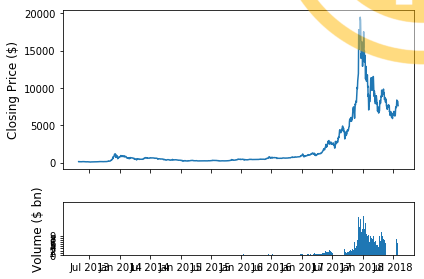

In [11]:
#ビットコインの価格をプロッティング
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
ax1.set_ylabel('Closing Price ($)',fontsize=12)
ax2.set_ylabel('Volume ($ bn)',fontsize=12)
ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
ax2.set_yticklabels(range(10))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(bitcoin_market_info['Date'].astype(datetime.datetime),bitcoin_market_info['bt_Open'])
ax2.bar(bitcoin_market_info['Date'].astype(datetime.datetime).values, bitcoin_market_info['bt_Volume'].values)
fig.tight_layout()
fig.figimage(bitcoin_im, 100, 120, zorder=3,alpha=.5)
plt.show()

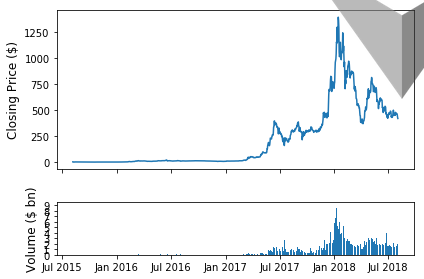

In [12]:
#ax1.set_yscale('log')
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
#ax1.set_yscale('log')
ax1.set_ylabel('Closing Price ($)',fontsize=12)
ax2.set_ylabel('Volume ($ bn)',fontsize=12)
ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
ax2.set_yticklabels(range(10))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(eth_market_info['Date'].astype(datetime.datetime),eth_market_info['eth_Open'])
ax2.bar(eth_market_info['Date'].astype(datetime.datetime).values, eth_market_info['eth_Volume'].values)
fig.tight_layout()
fig.figimage(eth_im, 300, 180, zorder=3, alpha=.6)
plt.show()
 

# Training Data, Test Data作成

In [19]:
# 両方のデータを結合する
market_info = pd.merge(bitcoin_market_info,eth_market_info, on=['Date'])
market_info = market_info[market_info['Date']>='2016-01-01']
for coins in ['bt_', 'eth_']: 
    kwargs = { coins+'day_diff': lambda x: (x[coins+'Close']-x[coins+'Open'])/x[coins+'Open']}
    market_info = market_info.assign(**kwargs)
market_info.head()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap,eth_Open,eth_High,eth_Low,eth_Close,eth_Volume,eth_Market Cap,bt_day_diff,eth_day_diff
0,2018-08-02,7634.19,7712.77,7523.44,7567.15,4214110000,131189721712,420.81,425.03,410.31,412.62,1569300000,42527933834,-0.008782,-0.019462
1,2018-08-01,7769.04,7769.04,7504.95,7624.91,4797620000,133492645169,433.87,435.46,410.46,420.75,1888060000,43839225862,-0.018552,-0.030239
2,2018-07-31,8181.20,8181.53,7696.93,7780.44,5287530000,140559547538,457.25,457.25,430.44,433.87,1820680000,46191809198,-0.048985,-0.051132
3,2018-07-30,8221.58,8235.50,7917.50,8180.48,5551400000,141239444979,466.83,467.95,448.64,457.08,2141590000,47150243495,-0.004999,-0.020886
4,2018-07-29,8205.82,8272.26,8141.18,8218.46,4107190016,140951371776,466.92,470.36,462.71,466.67,1631910016,47149572096,0.001540,-0.000535


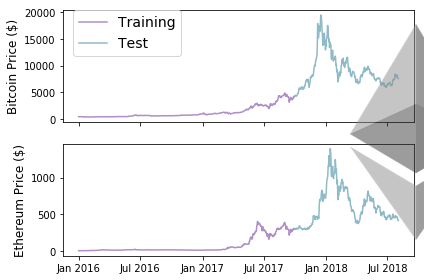

In [17]:
split_date = '2017-10-01'
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['bt_Close'], 
         color='#B08FC7', label='Training')
ax1.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['bt_Close'], 
         color='#8FBAC8', label='Test')
ax2.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['eth_Close'], 
         color='#B08FC7')
ax2.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['eth_Close'], color='#8FBAC8')
ax1.set_xticklabels('')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 14})
fig.figimage(bitcoin_im.resize((int(bitcoin_im.size[0]*0.65), int(bitcoin_im.size[1]*0.65)), Image.ANTIALIAS), 
             200, 260, zorder=3,alpha=.5)
fig.figimage(eth_im.resize((int(eth_im.size[0]*0.65), int(eth_im.size[1]*0.65)), Image.ANTIALIAS), 
             350, 40, zorder=3,alpha=.5)
plt.show()
 

# 機械学習ではない予測手法を使ってみる

## Lag Model

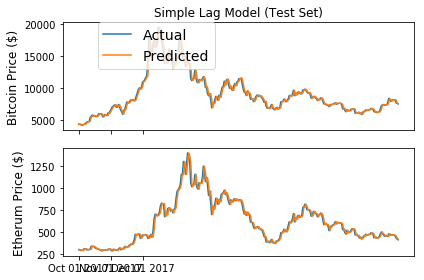

In [20]:
# 前日の価格を翌日の予想価格として扱うラグモデルの予測プロッティング
 
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['bt_Close'].values, label='Actual')
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
          market_info[market_info['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                      datetime.timedelta(days=1)]['bt_Close'][1:].values, label='Predicted')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.set_title('Simple Lag Model (Test Set)')
ax2.set_ylabel('Etherum Price ($)',fontsize=12)
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['eth_Close'].values, label='Actual')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
          market_info[market_info['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                      datetime.timedelta(days=1)]['eth_Close'][1:].values, label='Predicted')
fig.tight_layout()
plt.show()

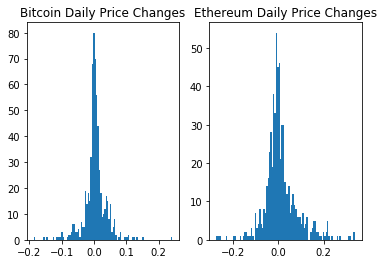

In [22]:
#価格変動のヒストグラムをみる
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hist(market_info[market_info['Date']< split_date]['bt_day_diff'].values, bins=100)
ax2.hist(market_info[market_info['Date']< split_date]['eth_day_diff'].values, bins=100)
ax1.set_title('Bitcoin Daily Price Changes')
ax2.set_title('Ethereum Daily Price Changes')
plt.show()
 

## Random walk model

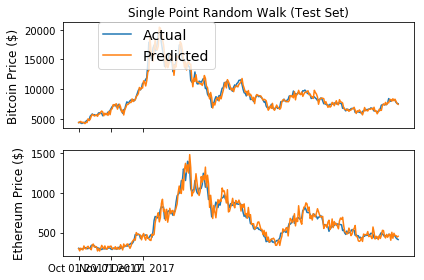

In [23]:
np.random.seed(202)
bt_r_walk_mean, bt_r_walk_sd = np.mean(market_info[market_info['Date']< split_date]['bt_day_diff'].values), \
                         np.std(market_info[market_info['Date']< split_date]['bt_day_diff'].values)
bt_random_steps = np.random.normal(bt_r_walk_mean, bt_r_walk_sd, 
                (max(market_info['Date']).to_pydatetime() - datetime.datetime.strptime(split_date, '%Y-%m-%d')).days + 1)
eth_r_walk_mean, eth_r_walk_sd = np.mean(market_info[market_info['Date']< split_date]['eth_day_diff'].values), \
                         np.std(market_info[market_info['Date']< split_date]['eth_day_diff'].values)
eth_random_steps = np.random.normal(eth_r_walk_mean, eth_r_walk_sd, 
                (max(market_info['Date']).to_pydatetime() - datetime.datetime.strptime(split_date, '%Y-%m-%d')).days + 1)
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
     market_info[market_info['Date']>= split_date]['bt_Close'].values, label='Actual')
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
      market_info[(market_info['Date']+ datetime.timedelta(days=1))>= split_date]['bt_Close'].values[1:] * 
     (1+bt_random_steps), label='Predicted')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
     market_info[market_info['Date']>= split_date]['eth_Close'].values, label='Actual')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
      market_info[(market_info['Date']+ datetime.timedelta(days=1))>= split_date]['eth_Close'].values[1:] * 
     (1+eth_random_steps), label='Predicted')
ax1.set_title('Single Point Random Walk (Test Set)')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.tight_layout()
plt.show()
 

# 注意
タイムシリーズモデル（時系列データの予測）で、このように一点のポイント（この場合だと翌日の価格のみ）を予測することは頻繁にありますが、上記のように一点（翌日のみ）の予測モデルを評価すると、騙されたように高い評価になってしまいます。より正しくモデルの評価をするため、複数のポイント（この場合だと複数の日にち）の予測を評価するという手法があります。

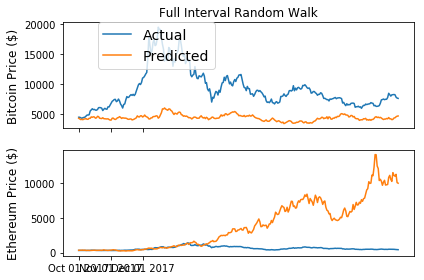

In [25]:
bt_random_walk = []
eth_random_walk = []
for n_step, (bt_step, eth_step) in enumerate(zip(bt_random_steps, eth_random_steps)):
    if n_step==0:
        bt_random_walk.append(market_info[market_info['Date']< split_date]['bt_Close'].values[0] * (bt_step+1))
        eth_random_walk.append(market_info[market_info['Date']< split_date]['eth_Close'].values[0] * (eth_step+1))
    else:
        bt_random_walk.append(bt_random_walk[n_step-1] * (bt_step+1))
        eth_random_walk.append(eth_random_walk[n_step-1] * (eth_step+1))
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['bt_Close'].values, label='Actual')
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         bt_random_walk[::-1], label='Predicted')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['eth_Close'].values, label='Actual')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         eth_random_walk[::-1], label='Predicted')
 
ax1.set_title('Full Interval Random Walk')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.tight_layout()
plt.show()

# LSTMを使って、予測する

ビットコインとイーサリアムの両通貨のデータへ、close_off_highとvolatilityを追加しましょう。close_off_highは同日のクローズ価格と高値の差を表す指標として追加しています。「-1」の値だと、その日の終値が底値と同じ値という意味です。同様に「1」の場場合は終値が高値と同じ値を表しています。

volatility（ボラティリティ）のカラムは、単純に同日の高値と底値の差額を始値で割った指標です。

In [34]:
for coins in ['bt_', 'eth_']: 
    kwargs = { coins+'close_off_high': lambda x: 2*(x[coins+'High']- x[coins+'Close'])/(x[coins+'High']-x[coins+'Low'])-1,
            coins+'volatility': lambda x: (x[coins+'High']- x[coins+'Low'])/(x[coins+'Open'])}
    market_info = market_info.assign(**kwargs)

In [35]:
#モデルで利用するパラメータを選定する
model_data = market_info[['Date']+[coin+metric for coin in ['bt_', 'eth_'] 
                                   for metric in ['Close','Volume','close_off_high','volatility']]]
# need to reverse the data frame so that subsequent rows represent later timepoints
model_data = model_data.sort_values(by='Date')
model_data.head()

,Date,bt_Close,bt_Volume,bt_close_off_high,bt_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
944,2016-01-01,434.33,36278900,-0.560137,0.020268,0.948024,206062,-0.418477,0.025040
943,2016-01-02,433.44,30096600,0.250597,0.009641,0.937124,255504,0.965898,0.034913
942,2016-01-03,430.01,39633800,-0.173865,0.020827,0.971905,407632,-0.317885,0.060792
941,2016-01-04,433.09,38477500,-0.474265,0.012649,0.954480,346245,-0.057657,0.047943
940,2016-01-05,431.96,34522600,-0.013333,0.010391,0.950176,219833,0.697930,0.025236


## 今回構築するLSTMの予測モデルですが、ビットコインとイサーリアムの過去の価格データを学習して、次の日の価格を予測するモデルとなります

In [36]:
# dateのカラムを削除
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [37]:
# 「窓」を10日に設定してあげます
# 終値と取引量を正規化
window_len = 10
norm_cols = [coin+metric for coin in ['bt_', 'eth_'] for metric in ['Close','Volume']]

In [38]:
# トレーニングとテストのデータセットを「窓」で分ける
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['eth_Close'][window_len:].values/training_set['eth_Close'][:-window_len].values)-1
 
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['eth_Close'][window_len:].values/test_set['eth_Close'][:-window_len].values)-1
 
#最後にトレーニングのインプットデータを確認してみましょう
LSTM_training_inputs[0]
 

,bt_Close,bt_Volume,bt_close_off_high,bt_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
944,0.000000,0.000000,-0.560137,0.020268,0.000000,0.000000,-0.418477,0.025040
943,-0.002049,-0.170410,0.250597,0.009641,-0.011498,0.239937,0.965898,0.034913
942,-0.009946,0.092475,-0.173865,0.020827,0.025190,0.978201,-0.317885,0.060792
941,-0.002855,0.060603,-0.474265,0.012649,0.006810,0.680295,-0.057657,0.047943
940,-0.005457,-0.048411,-0.013333,0.010391,0.002270,0.066829,0.697930,0.025236
939,-0.012019,-0.061645,-0.003623,0.012782,0.002991,0.498534,-0.214540,0.026263
938,0.054613,1.413585,-0.951499,0.069045,-0.006349,2.142074,0.681644,0.040587
937,0.043515,0.570968,0.294196,0.032762,0.040890,1.647747,-0.806717,0.055274
936,0.030576,-0.110282,0.814194,0.017094,0.040937,0.098121,-0.411897,0.019021
935,0.031451,-0.007801,-0.919598,0.017758,0.054014,0.896944,-0.938235,0.025266
